## Homework 5: Diffusion Models

### Run the following code to setup the necessary requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a EECS442 folder and put all the files under HW5 folder, then 'EECS442/HW5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS442/HW5'

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)


In [ ]:
print(GOOGLE_DRIVE_PATH)

You need to change your working directory.

In [ ]:
%cd /content/drive/MyDrive/EECS442/HW5

In [ ]:
!pip install certifi>=2022.9.14
!pip install charset-normalizer>=2.1.1
!pip install contourpy>=1.0.5
!pip install cycler>=0.11.0
!pip install fonttools>=4.37.2
!pip install idna>=3.4
!pip install kiwisolver>=1.4.4
!pip install matplotlib>=3.6.0
!pip install numpy>=1.23.3
!pip install packaging>=21.3
!pip install Pillow>=9.2.0
!pip install pyparsing>=3.0.9
!pip install python-dateutil>=2.8.2
!pip install PyYAML>=6.0
!pip install requests>=2.28.1
!pip install scipy>=1.9.1
!pip install six>=1.16.0
!pip install tqdm>=4.64.1
!pip install typing-extensions>=4.3.0
!pip install urllib3>=1.26.12


In [ ]:
!nvidia-smi

## Task 1: Unconditional Sampling with DDPM

### Setup

In [2]:
from functools import partial
import os
import argparse
import yaml

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from util.logger import get_logger
# GPUs are preferred
logger = get_logger()
device_str = f"cuda:0" if torch.cuda.is_available() else 'cpu'
logger.info(f"Device set to {device_str}.")
device = torch.device(device_str)

# set output directory
save_dir = 'results'
ddpm_out_path = os.path.join(save_dir, 'uncond_ddpm')
os.makedirs(ddpm_out_path, exist_ok=True)
for img_dir in ['input', 'output', 'progress']:
    os.makedirs(os.path.join(ddpm_out_path, img_dir), exist_ok=True)


2024-04-08 21:21:13,762 [DPS] >> Device set to cuda:0.


In this task, you will implement the sampling Algorithm proposed in Denoising Diffusion Probabilistic Models(DDPM) paper as shown below:


![](https://drive.google.com/uc?export=view&id=1Nz3QHfWxdTHcl0NkJt0BsUUTj0RCx7o9)


(1) Now let's implement the variance schedule. As you can see in the DDPM sampling algorithm, We will need $\alpha_t$ for each timestep $t$. $\alpha_t$ is a notaion for $1-\beta_t$, where $\beta_t$ is the true variance that increases from $t=1$ to $t=T$. There are many different variance shedules such as linear schedule and cosine schedule. Follow the instruction in `guided_diffusion/simple_diffusion.py` to implement `get_named_beta_schedule()`.


Cosine schedule is proposed by [iDDPM](https://arxiv.org/pdf/2102.09672.pdf). You can find the detailed motivation in the paper. The calulation of $\beta$ depends on $\alpha$, the cumulated product of $\alpha$ is defined as $$\bar{\alpha}_t=\frac{f(t)}{f(0)}$$,
where
$$f(t)=\cos\left({\frac{t/T+s}{1+s}}\cdot{\frac{\pi}{2}}\right)^{2}$$
We use small $s=0.008$ such that $\sqrt{\beta_0}$ was slightly smaller than the pixel
bin size 1/127.5.
According to the definition of $\alpha_t$, we can then get $\beta_t$ as
$$\beta_t=1-\frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$$

Also, clip $\beta_t$ to be no larger than
0.999 to prevent singularities at the end of the diffusion process.


Run the following code to see your output.

In [3]:
from guided_diffusion.simple_diffusion import get_named_beta_schedule
import numpy as np

num_steps = 1000
schedule_name = 'cosine'

print('Cosine Error: ', np.sum(get_named_beta_schedule(schedule_name, num_steps) - np.load("cosine_schedule.npy")))

/home/umhws/anaconda3/envs/eecs442/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cosine Error:  -6.661338147750939e-16


(2) Now you have implemented your variance schedule $\{\beta_1, \beta_2, ..., \beta_T\}$. In practice, we use $\alpha_t$ and accumulated product ${\overline{\alpha}}_t = \prod_{i=1}^t \alpha_i$. **Follow the instruction to complete `__init__()` of `DDPMDiffusion`** to compute the needed values that will be used during the sampling process. They only need to be calculated once during initialzation and we can directly access them later during sampling.

Hint: You can use `np.cumprod()` to calculate the cumulated product.

Let's now create the model.

Before you run the code below, make sure that you have downloaded the pretrained model
[ffhq_10M.pt](https://drive.google.com/drive/folders/1jElnRoFv7b31fG0v6pTSQkelbSX3xGZh?usp=sharing) and put it under `model` directory.

In [4]:
from guided_diffusion.unet import create_model
from data.dataloader import get_dataset, get_dataloader

# Here is the model configuration of the Pretrained UNet model that we will be using.
# This configuration should be consistent with the pretrained model, so you don't need to modify them.
# You can find the detailed definition of the UNet in guided_diffusion/unet.py

model_config = {
    'image_size': 256,
    'num_channels': 128,
    'num_res_blocks': 1,
    'channel_mult': "",
    'learn_sigma': True,
    'class_cond': False,
    'use_checkpoint': False,
    'attention_resolutions': 16,
    'num_heads': 4,
    'num_head_channels': 64,
    'num_heads_upsample': -1,
    'use_scale_shift_norm': True,
    'dropout': 0.0,
    'resblock_updown': True,
    'use_fp16': False,
    'use_new_attention_order': False,
    'model_path': 'models/ffhq_10m.pt'
}

# Load model
ddpm_beta = get_named_beta_schedule('linear', 1000)

model = create_model(betas=ddpm_beta, **model_config)
model = model.to(device)
model.eval()  # Set the model to the evaluation mode as we don't need to train it.


pretrained model loaded!


UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stri

(3) Now we need to implement the posterior sampling of DDPM as shown in line 4 in Algorithm 2. As you can notice that in the original sampling algorithm of DDPM, the model is trained to predict the noise $\epsilon$.

Our pretrained model takes $x_t$ and $t$ as input and predict the noise $\epsilon$.

What's more, our model is also trained to predict the variance $\sigma_t$. The model output is a torch tensor of shape $(B, C, H, W)$, where $B$ is the batch size, $C$ is the number of channels and $H$, $W$ are the height and width respectively. $C$ here for our model is 6, with the first 3 channels for the noise prediction $\epsilon$ and the last 3 chennels for $\sigma_t$.

Implement the `p_sample` function of `DDPMDiffusion` in `guided_diffusion/simple_diffusion.py` for unconditional posterior sampling. Follow the sampling algorithm. Attach your code to the report.

(4) Now we have everything we need to perform unconditional sampling!

Implement the `p_sample_loop` of `DDPMDiffusion` in `simple_diffusion.py` for unconditional sampling, using the DDPM sampling algorithm.

(6) Run the code below to see what we can get from unconditional distillation. Include your results in your report.

In [5]:
from guided_diffusion.simple_diffusion import *
import torchvision
from util.img_utils import clear_color, mask_generator
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from util.img_utils import clear_color, mask_generator
from PIL import Image

In [6]:
diffusion_config = {
    'sampler': 'ddpm',
    'steps': 1000,
    'noise_schedule': 'linear',
    'model_mean_type': 'epsilon',
    'model_var_type': 'learned_range',
    'dynamic_threshold': False,
    'clip_denoised': True,
    'rescale_timesteps': False,
    'timestep_respacing': 1000}

sampler = create_sampler(**diffusion_config) # Instantiate DDPMDiffusion
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=None) # Having some function input fixed

x_start = torch.randn((1, 3, 256, 256), device=device)
out_path = os.path.join(save_dir, 'uncond_ddpm')


In [ ]:
sample = sample_fn(x_start=x_start, measurement=None, record=True, save_root=out_path, uncond=True)

We start from random noise of the same size as our output image:

In [ ]:
torchvision.transforms.functional.to_pil_image((x_start[0] + 1)/2)

We can then generate human faces with our pretrained model when given the noise input:

In [ ]:
plt.imsave(os.path.join(out_path, 'output', '0.png'), clear_color(sample))
torchvision.transforms.functional.to_pil_image((sample[0] + 1)/2)

## Task 2: Unconditional Samping with DDIM

In this task, you will implement an improved sampling algorithm from Denoising Diffusion Implicit Models(DDIM) paper. DDIM sampling applies an improved update rule to sample from $p(x_{t-1}|x_t, x_0)$. The update rule is given by

![](https://drive.google.com/uc?id=1_a9OdUeRRb5PPDJrQhT_8QjpLBKC812U)



Leveraging the above improved update rule, DDIM can be used to accelerate the sampling algorithm by only using a subset of the timesteps as before.

In `simple_diffusion.py` update the method `p_sample` under the class `DDIMDiffusion`, to implement the above update rule for DDIM sampling.

In [16]:
timestep_spacing = 100

diffusion_config = {
    'sampler': 'ddim',
    'steps': 1000,
    'noise_schedule': 'linear',
    'model_mean_type': 'epsilon',
    'model_var_type': 'learned_range',
    'dynamic_threshold': False,
    'clip_denoised': True,
    'rescale_timesteps': True,
    'timestep_respacing': f'ddim{timestep_spacing}'}


sampler = create_sampler(**diffusion_config)
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=None)

x_start = torch.randn((1, 3, 256, 256), device=device)
out_path = os.path.join(save_dir, 'uncond_ddim')
save_path = os.path.join(out_path, "progress")
os.makedirs(save_path, exist_ok=True)

In [12]:
sample = sample_fn(x_start=x_start, measurement=None, record=True, save_root=out_path, uncond = True)

100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


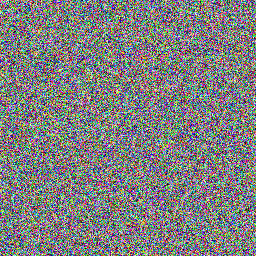

In [13]:
x_start_plot = to_pil_image((x_start[0] + 1)/2)
x_start_plot

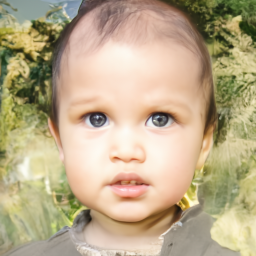

In [14]:
sample_plot = to_pil_image((sample[0] + 1)/2)
sample_plot

## Task 3: Inverse problem with RePaint

In this task, you will be applying the generative DDPM to solve an interesting problem of Image Inpainting. Image inpainting refers to filling out regions of the image that are unknown apriori. Here, we assume that a mask $m$ indicating the known region is given to us.

Repaint Diffusion applies an update rule to the input image as shown below,

![](https://drive.google.com/uc?id=1Z2rrGAmNTKBzEqrqyKJ7p96lOrtl8_eS)

where the known region is sampled using

$x^{known}_{t-1} \sim N\:(\:\bar{\alpha}_t  x_0, \:(1 - \bar{\alpha}_t)\:I\:)$

and the unknown region is sampled from the diffusion model as

$x^{unknown}_{t-1} \sim N\:(\mu_{\theta}(\: x_t, \:t), \:\Sigma_{\theta}(\: x_t, \:t))$

and the new sample $x_{t-1}$ is obtained using

$x_{t-1} = m ⨀ x^{known}_{t-1} + (1 - m) ⨀ x^{unknown}_{t-1} $

In `simple_diffusion.py` update the method `p_sample` under the class `Repaint`, to implement the above update rule for inpainting.



The summarized algorithm is given by

![](https://drive.google.com/uc?id=1dLxuhCUCf_pkK4HLsbrygs90PBWkJwk3)

In [23]:
repaint_beta = get_named_beta_schedule('linear', 1000)

model_config = {
    'image_size': 256,
    'num_channels': 128,
    'num_res_blocks': 1,
    'channel_mult': "",
    'learn_sigma': True,
    'class_cond': False,
    'use_checkpoint': False,
    'attention_resolutions': 16,
    'num_heads': 4,
    'num_head_channels': 64,
    'num_heads_upsample': -1,
    'use_scale_shift_norm': True,
    'dropout': 0.0,
    'resblock_updown': True,
    'use_fp16': False,
    'use_new_attention_order': False,
    'model_path': 'models/ffhq_10m.pt'
}


diffusion_config = {
    'sampler': 'repaint',
    'steps': 1000,
    'noise_schedule': 'linear',
    'model_mean_type': 'epsilon',
    'model_var_type': 'learned_range',
    'dynamic_threshold': False,
    'clip_denoised': True,
    'rescale_timesteps': True,
    'timestep_respacing': 250}

repaint_conf = {
    "name": "face_example",
    "inpa_inj_sched_prev": True,
    "n_jobs": 1,
    "print_estimated_vars": True,
    "inpa_inj_sched_prev_cumnoise": False,
    "class_cond": False,
    "schedule_jump_params":{
        "t_T": 250,
        "n_sample": 1,
        "jump_length": 10,
        "jump_n_sample": 10,
    }
}

repaint_model = create_model(betas=repaint_beta, **model_config)
repaint_model = repaint_model.to(device)
repaint_model.eval()
print("Model Loaded")

gt_path = "data/datasets/gts/face/000000.png"
gt_mask_path = "data/datasets/gt_keep_masks/face/000000.png"

pretrained model loaded!
Model Loaded


In [24]:
model_kwargs_keys = ['gt', 'gt_keep_mask']

pil_gt_image = Image.open(gt_path)
gt_tensor = (pil_to_tensor(pil_gt_image) / 127.5 - 1.0).to(device = 'cuda')

pil_gt_mask = Image.open(gt_mask_path)
gt_mask_tensor = (pil_to_tensor(pil_gt_mask) / 255.0).to(device = 'cuda')

model_kwargs = {
    'gt': gt_tensor,
    'gt_keep_mask': gt_mask_tensor
}

In [25]:
sampler = create_sampler(**diffusion_config)
sample_fn = partial(sampler.p_sample_loop, model=repaint_model, shape=(1, 3, 256, 256), conf = repaint_conf, model_kwargs = model_kwargs)

x_start = torch.randn((1, 3, 256, 256), device=device)
out_path = os.path.join(save_dir, 'repaint')
save_path = os.path.join(out_path, "progress")
os.makedirs(save_path, exist_ok=True)

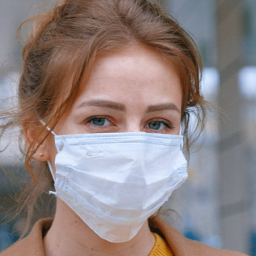

In [26]:
pil_gt_image

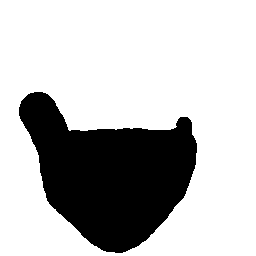

In [27]:
pil_gt_mask

100%|██████████| 4570/4570 [02:29<00:00, 30.51it/s]


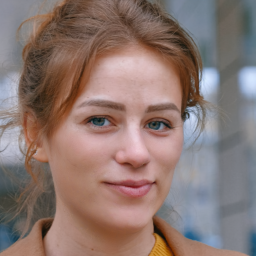

In [28]:
sample = sample_fn(noise=x_start, progress = True)
to_pil_image((sample[0] + 1)/2)

## Task 4: Inverse problem with DPS

In this task, you will implement the sampling algorithm with posterior sampling using a pre-trained diffusion model. This is prettey much similar to the unconditional sampling algorithm except that we now are given the corrupted input. Let's implement the algorithm below.
![](https://drive.google.com/uc?export=view&id=1SCjAe3UjzjLLW87ftzzcTbgm6rf-_Rlb)

The algorithm follows the same process as unconditional sampling. The only difference here is that we need to use the prior provided by the diffusion model and optimize the **image** directly by take taking the derivative in line 7.

(1) We have already implemented the conditional sampling part of `p_sample_loop` and `p_sample` of `DPSDiffusion` in `guided_diffusion/simple_diffusion.py` for conditional posterior sampling. But we do encourage you to take a look that into that.

(2)You will need to implment the `PosteriorSampling` in `guided_diffusion/condition_methods.py`.

(3) Run the following code. You should report one sample(including the raw image, corrupted image input and the algorithm output) of the inpainting task.

(4) [Optional] Play around with other task configurations and operate the algorithm to see how the results look like. Report one sample(including the raw image, corrupted image input and the algorithm output) of the following task: motion deblur, gaussain deblur and super resolution. Compare the results and discuss how the algorithm perform in each task.
[Hint: Change `task_config` to paly with different tasks]


In [29]:
from guided_diffusion.measurements import get_noise, get_operator
from guided_diffusion.condition_methods import get_conditioning_method
from util.img_utils import clear_color, mask_generator
from PIL import Image

In [30]:
# Prepare dataloader
# data_config = task_config['data']
data_config = {
    'name': 'ffhq',
    'root': './data/samples/'}
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

# configuration of inpainting task
task_config_inpainting = {'conditioning':
            {'method': 'ps',
             'params': {'scale': 0.5}},
        'measurement':
            {'operator': {'name': 'inpainting'},
             'mask_opt':
             {'mask_type': 'random',
              'mask_prob_range': (0.3, 0.7),
              'image_size': 256},
              'noise': {'name': 'gaussian', 'sigma': 0.05}}
             }

# configuration of motion-deblur task
task_config_motion_deblur = {'conditioning':
            {'method': 'ps',
             'params': {'scale': 0.3}},
        'measurement':
            {'operator': {
                'name': 'motion_blur',
                'kernel_size': 61,
                'intensity': 0.5},
              'noise': {'name': 'gaussian', 'sigma': 0.05}}
             }

# configuration of gaussian-deblur task
task_config_gaussian_deblur = {'conditioning':
            {'method': 'ps',
             'params': {'scale': 0.3}},
        'measurement':
            {'operator': {
                'name': 'gaussian_blur',
                'kernel_size': 61,
                'intensity': 3.0},
              'noise': {'name': 'gaussian', 'sigma': 0.05}}
             }

# configuration of super resolution task
task_config_super_resolution = {'conditioning':
            {'method': 'ps',
             'params': {'scale': 0.3}},
        'measurement':
            {'operator': {
                'name': 'super_resolution',
                'in_shape': (1, 3, 256, 256),
                'scale_factor': 4},
              'noise': {'name': 'gaussian', 'sigma': 0.05}}
             }

task_config = task_config_inpainting

measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")

# Prepare conditioning method
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
measurement_cond_fn = cond_method.conditioning
logger.info(f"Conditioning method : {task_config['conditioning']['method']}")

diffusion_config = {
    'sampler': 'dps',
    'steps': 1000,
    'noise_schedule': 'linear',
    'model_mean_type': 'epsilon',
    'model_var_type': 'learned_range',
    'dynamic_threshold': False,
    'clip_denoised': True,
    'rescale_timesteps': False,
    'timestep_respacing': 1000}

sampler = create_sampler(**diffusion_config)
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=measurement_cond_fn, uncond=False)

out_path = os.path.join(save_dir, measure_config['operator']['name'])
os.makedirs(out_path, exist_ok=True)
for img_dir in ['input', 'recon', 'progress', 'label']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)


2024-04-09 01:15:50,275 [DPS] >> Operation: inpainting / Noise: gaussian
2024-04-09 01:15:50,277 [DPS] >> Conditioning method : ps


DPS Initialized!


In [31]:
if measure_config['operator']['name'] == 'inpainting':
        mask_gen = mask_generator(
           **measure_config['mask_opt']
        )

for i, ref_img in enumerate(loader):
        logger.info(f"Inference for image {i}")
        fname = str(i).zfill(5) + '.png'
        ref_img = ref_img.to(device)

        # Exception) In case of inpainging,
        if measure_config['operator'] ['name'] == 'inpainting':
            mask = mask_gen(ref_img)
            mask = mask[:, 0, :, :].unsqueeze(dim=0)
            measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
            sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)

            # Forward measurement model (Ax + n)
            y = operator.forward(ref_img, mask=mask)
            y_n = noiser(y)

        else:
            # Forward measurement model (Ax + n)
            y = operator.forward(ref_img)
            y_n = noiser(y)

        # Sampling
        x_start = torch.randn(ref_img.shape, device=device).requires_grad_()
        sample = sample_fn(x_start=x_start, measurement=y_n, record=True, save_root=out_path, uncond=False)

        plt.imsave(os.path.join(out_path, 'input', fname), clear_color(y_n))
        plt.imsave(os.path.join(out_path, 'label', fname), clear_color(ref_img))
        plt.imsave(os.path.join(out_path, 'recon', fname), clear_color(sample))

        break

2024-04-09 01:15:54,288 [DPS] >> Inference for image 0
100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s]


Now let's visualize some results.

Runnig the code below to visualize the raw image:

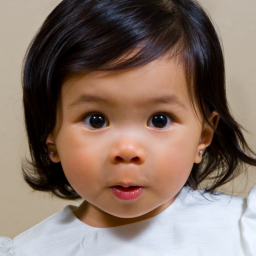

In [32]:
Image.open(os.path.join(out_path, 'label', '00000.png'))

And here is the corrupted image by random masks:

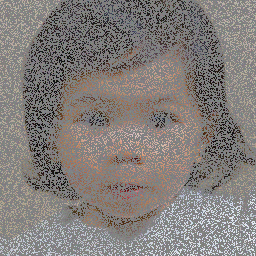

In [33]:
Image.open(os.path.join(out_path, 'input', '00000.png'))

Now let's see how our algorithm works:

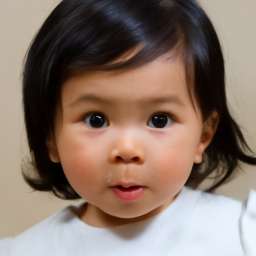

In [34]:
Image.open(os.path.join(out_path, 'recon', '00000.png'))